In [0]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe

In [0]:
tf.enable_eager_execution()


In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.8 #@param {type:"number"}
LEARNING_RATE = 9.0 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.conv(inputs)))

In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

In [0]:
class DavidNet(tf.keras.Model):
  def __init__(self, c=32, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(64, pool, res = True)
    self.blk2 = ResBlk(96, pool)
    self.blk3 = ResBlk(128, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

In [0]:
!cp '/floyd/input/imageaug/0_x.npy' .
!cp '/floyd/input/imageaug/1_x.npy' .
!cp '/floyd/input/imageaug/2_x.npy' .
!cp '/floyd/input/imageaug/3_x.npy' .
!cp '/floyd/input/imageaug/4_x.npy' .
!cp '/floyd/input/imageaug/5_x.npy' .
!cp '/floyd/input/imageaug/6_x.npy' .
!cp '/floyd/input/imageaug/7_x.npy' .
!cp '/floyd/input/imageaug/8_x.npy' .
!cp '/floyd/input/imageaug/9_x.npy' .
!cp '/floyd/input/imageaug/10_x.npy' .
!cp '/floyd/input/imageaug/11_x.npy' .

!cp '/floyd/input/imageaug/0_y.npy' .
!cp '/floyd/input/imageaug/1_y.npy' .
!cp '/floyd/input/imageaug/2_y.npy' .
!cp '/floyd/input/imageaug/3_y.npy' .
!cp '/floyd/input/imageaug/4_y.npy' .
!cp '/floyd/input/imageaug/5_y.npy' .
!cp '/floyd/input/imageaug/6_y.npy' .
!cp '/floyd/input/imageaug/7_y.npy' .
!cp '/floyd/input/imageaug/8_y.npy' .
!cp '/floyd/input/imageaug/9_y.npy' .
!cp '/floyd/input/imageaug/10_y.npy' .
!cp '/floyd/input/imageaug/11_y.npy' .






In [0]:
augmented_x_files = ['0_x.npy', '1_x.npy', '2_x.npy','3_x.npy', '4_x.npy', '5_x.npy',
                     '6_x.npy', '7.npy', '8_x.npy','9_x.npy', '10_x.npy', '11_x.npy']


augmented_y_files = ['0.npy','1.npy','2.npy','3.npy','4.npy','5.npy',
                    '6.npy','7'.npy','8.npy','9.npy','10.npy','11.npy']

combined_x_aug = None
combined_y_aug = None

In [0]:
for x_file_name in augmented_x_files[:2]:
    aug_x = np.load(x_file_name, encoding='latin1')
    if combined_x_aug is None:
        combined_x_aug = aug_x
    else:
        combined_x_aug = np.append(combined_x_aug, aug_x, axis=0)
    
for y_file_name in augmented_y_files[:2]:
    aug_y = np.load(y_file_name, encoding='latin1')
    if combined_y_aug is None:
        combined_y_aug = aug_y
    else:
        combined_y_aug = np.append(combined_y_aug, aug_y)        
    

In [0]:
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

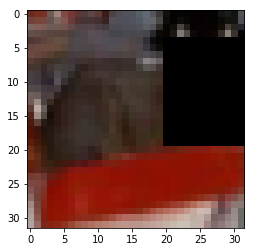

In [0]:
img = combined_x_aug[1]   
plt.imshow(img)

In [0]:
combined_y_aug[1]

2

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)



170500096/170498071 [==============================] - 6s 0us/step


In [0]:
def create_combined_aug_train_list(x_train,y_train,aug_x, aug_y, no_of_times):
    x_train_aug = None
    y_train_aug = None
    for i in range(no_of_times):
        random_index_list = np.random.rand(50000).argsort()
        temp_x_train_list = x_train[random_index_list[:25000]]
        temp_y_train_list = y_train[random_index_list[:25000]]
        temp_aug_x_list = aug_x[i*25000: (i+1)*25000]
        temp_aug_y_list = aug_y[i*25000: (i+1)*25000]
        temp_x_train_aug = np.append(temp_x_train_list, temp_aug_x_list, axis=0)      
        temp_y_train_aug = np.append(temp_y_train_list, temp_aug_y_list, axis=0)
        random_index_list = np.random.rand(50000).argsort()
        temp_x_train_aug = temp_x_train_aug[random_index_list]
        temp_y_train_aug = temp_y_train_aug[random_index_list]
      
        if x_train_aug is None:
            x_train_aug = temp_x_train_aug
            y_train_aug = temp_y_train_aug
        else:
            x_train_aug = np.append(x_train_aug, temp_x_train_aug, axis=0)
            y_train_aug = np.append(y_train_aug, temp_y_train_aug, axis=0)
      
    return x_train_aug, y_train_aug  
    
    

In [0]:
x_train_aug, y_train_aug  = create_combined_aug_train_list(x_train,y_train,combined_x_aug, combined_y_aug, 12)

In [0]:
x_train_aug.shape

(100000, 32, 32, 3)

In [0]:
train_mean = np.mean(x_train_aug, axis=(0,1,2))
train_std = np.std(x_train_aug, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train_aug = normalize(pad4(x_train_aug))
x_test = normalize(x_test)

In [0]:
x_train.shape

(50000, 32, 32, 3)

In [0]:
y_train.shape

(50000,)

In [0]:
model = DavidNet()
batches_per_epoch = len_train//BATCH_SIZE + 1

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)

In [0]:
t = time.time()
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  #train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)
  train_set = tf.data.Dataset.from_tensor_slices((x_train_aug[epoch*50000:(epoch+1)*50000], y_train_aug[epoch*50000:(epoch+1)*50000])).batch(BATCH_SIZE).prefetch(1)

  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()
    
  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)


epoch: 1 lr: 1.8 train loss: 1.4629514971923827 train acc: 0.46802 val loss: 1.2344836517333984 val acc: 0.5679 time: 82.46579051017761



epoch: 2 lr: 3.6 train loss: 0.8371428315734863 train acc: 0.70774 val loss: 1.1328723419189453 val acc: 0.622 time: 157.75106072425842



epoch: 3 lr: 5.4 train loss: 0.7661604789733887 train acc: 0.74289 val loss: 1.2507989379882813 val acc: 0.5991 time: 233.16759324073792



epoch: 4 lr: 7.2 train loss: 0.8192239708709717 train acc: 0.73065 val loss: 1.1541218719482422 val acc: 0.6168 time: 308.2236430644989



epoch: 5 lr: 9.0 train loss: 0.9152791751098632 train acc: 0.70398 val loss: 7.91887197265625 val acc: 0.2077 time: 383.43316435813904



epoch: 6 lr: 8.526315789473685 train loss: 0.845936466217041 train acc: 0.7082 val loss: 1.2436774047851562 val acc: 0.5891 time: 458.3292627334595



epoch: 7 lr: 8.052631578947368 train loss: 0.5519545721435547 train acc: 0.80829 val loss: 1.1949388000488281 val acc: 0.6147 time: 533.3773834705353



epoch: 8 lr: 7.578947368421053 train loss: 0.4441435782623291 train acc: 0.84524 val loss: 0.9687178649902344 val acc: 0.6875 time: 608.1045830249786



epoch: 9 lr: 7.105263157894737 train loss: 0.3685045113372803 train acc: 0.87093 val loss: 0.8409268341064453 val acc: 0.7287 time: 683.3249957561493



epoch: 10 lr: 6.631578947368421 train loss: 0.30982126556396483 train acc: 0.89145 val loss: 0.9405127365112305 val acc: 0.7125 time: 758.0756361484528



epoch: 11 lr: 6.157894736842105 train loss: 0.25811228668212893 train acc: 0.90979 val loss: 0.9265366333007813 val acc: 0.7241 time: 833.0247519016266



epoch: 12 lr: 5.684210526315789 train loss: 0.2195078625679016 train acc: 0.9221 val loss: 0.9871583374023437 val acc: 0.7251 time: 907.8477411270142



epoch: 13 lr: 5.210526315789474 train loss: 0.18448486755371094 train acc: 0.93494 val loss: 1.0282983459472657 val acc: 0.7349 time: 982.9797194004059



epoch: 14 lr: 4.736842105263158 train loss: 0.15301637775421142 train acc: 0.94554 val loss: 1.037606381225586 val acc: 0.7508 time: 1057.7153389453888



epoch: 15 lr: 4.2631578947368425 train loss: 0.12482227130889892 train acc: 0.95657 val loss: 1.1320917938232422 val acc: 0.7352 time: 1132.6152157783508



epoch: 16 lr: 3.7894736842105265 train loss: 0.0925480893421173 train acc: 0.96712 val loss: 1.5106195098876953 val acc: 0.6982 time: 1207.2950088977814



epoch: 17 lr: 3.3157894736842106 train loss: 0.07122918380737304 train acc: 0.97482 val loss: 1.320445346069336 val acc: 0.7375 time: 1282.3916325569153



epoch: 18 lr: 2.8421052631578947 train loss: 0.04992698495864868 train acc: 0.98253 val loss: 1.6278551971435546 val acc: 0.7148 time: 1357.0737798213959



epoch: 19 lr: 2.3684210526315796 train loss: 0.030563690843582153 train acc: 0.98976 val loss: 1.3469409118652345 val acc: 0.7602 time: 1432.1037216186523



epoch: 20 lr: 1.8947368421052637 train loss: 0.01646588268995285 train acc: 0.99532 val loss: 1.3176430938720702 val acc: 0.7667 time: 1506.6960639953613



epoch: 21 lr: 1.4210526315789478 train loss: 0.007702856873273849 train acc: 0.99839 val loss: 1.338818392944336 val acc: 0.7691 time: 1581.583359003067



epoch: 22 lr: 0.9473684210526319 train loss: 0.0036417261520028115 train acc: 0.99955 val loss: 1.3791298645019532 val acc: 0.771 time: 1656.1269047260284



epoch: 23 lr: 0.4736842105263168 train loss: 0.0023746040600538254 train acc: 0.99978 val loss: 1.400496841430664 val acc: 0.7706 time: 1730.9191403388977



epoch: 24 lr: 0.0 train loss: 0.0019786288926005365 train acc: 0.99981 val loss: 1.4073136596679687 val acc: 0.7699 time: 1805.6415901184082
